In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

In [25]:
df = pd.read_csv("../smalldata/attack-sum-count.csv")
df["date"] = pd.to_datetime(df.loc[:, ["year", "month", "day", "hour"]])
df.drop(columns=["year", "month", "day", "hour"], inplace=True)
df.set_index("date", inplace=True)
df

,sumCount
date,
2019-09-23 07:00:00,1878655
2019-09-19 10:00:00,1654071
2019-09-17 16:00:00,1677510
2019-09-18 18:00:00,1664228
2019-09-19 06:00:00,1534700
...,...
2019-09-04 23:00:00,1261044
2019-09-29 00:00:00,1602877
2018-09-26 00:00:00,1657392


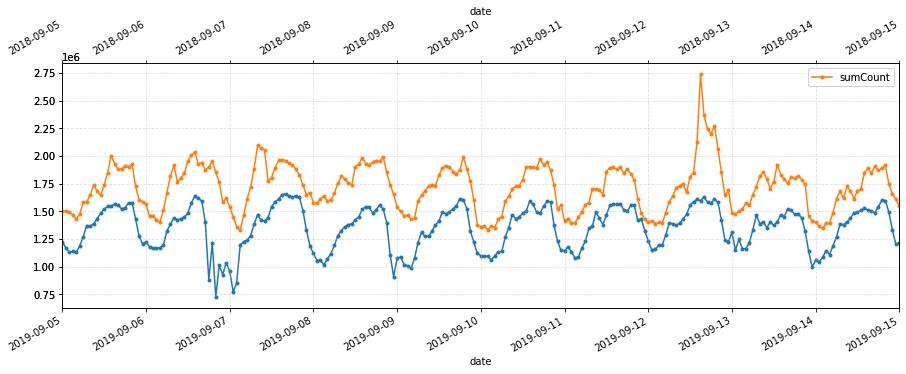

In [60]:
fig, ax1 = plt.subplots(figsize=(15,5))
df[df.index.year == 2019].plot(ax=ax1, marker=".", label="2019")
ax2 = ax1.twiny()
df[df.index.year == 2018].plot(ax=ax2, color="C1", marker=".", label="2018")

ax1.set_xlim("2019-09-05", "2019-09-15")
ax2.set_xlim("2018-09-05", "2018-09-15")
plt.grid(linestyle="--", alpha=0.4)
plt.show()

In [4]:
df2 = pd.read_parquet("../../smalldata/A1.parquet")
df2["date"] = pd.to_datetime(df2.loc[:, ["year", "month", "day", "hour"]])
df2.drop(columns=["year", "month", "day", "hour"], inplace=True)
df2.set_index("date", inplace=True)
df2

,trafficType,domain,sumCount
date,,,
2018-09-01 00:00:00,user,cs.wiktionary,54
2018-09-01 00:00:00,user,tg.wiktionary,5
2018-09-01 00:00:00,user,tn.wikipedia,4
2018-09-01 00:00:00,spider,bh.wikipedia,57
2018-09-01 00:00:00,spider,la.wikisource,20
...,...,...,...
2019-09-30 23:00:00,spider,ht.wikisource,28
2019-09-30 23:00:00,spider,ug.wikiquote,12
2019-09-30 23:00:00,spider,ceb.wikipedia,1545


In [157]:
def getdfcols(df):
    l = [df.index.to_numpy()]
    try:
        for c in df.columns:
            l.append(df[c].to_numpy())
    except AttributeError:
        # its probably a series ...
        l.append(df.to_numpy())
    return l

In [158]:
df_spider = df2[df2["trafficType"]=="spider"].groupby(["date"]).sum(["sumCount"])
df_user = df2[df2["trafficType"]=="user"].groupby(["date"]).sum(["sumCount"])

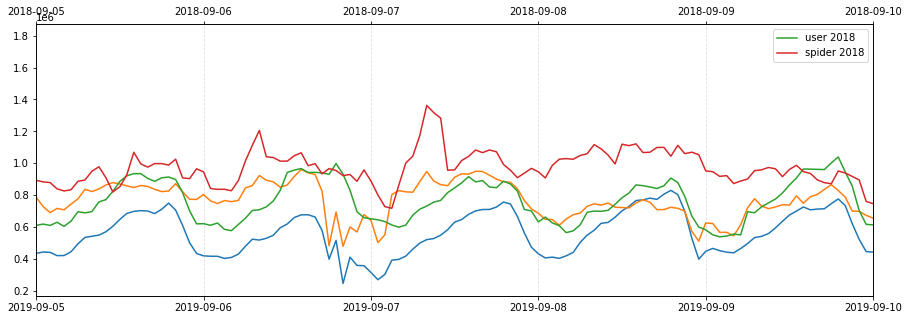

In [159]:
fig, ax1 = plt.subplots(figsize=(15,5))
ax1.plot(df_user[df_user.index.year == 2019], label="user 2019", color="C0")
ax1.plot(df_spider[df_spider.index.year == 2019], label="spider 2019", color="C1")
ax2 = ax1.twiny()
ax2.plot(df_user[df_user.index.year == 2018], label="user 2018", color="C2")
ax2.plot(df_spider[df_spider.index.year == 2018], label="spider 2018", color="C3")

ax1.set_xlim(datetime.date(2019, 9, 5), datetime.date(2019, 9, 10))
ax2.set_xlim(datetime.date(2018, 9, 5), datetime.date(2018, 9, 10))
plt.grid(linestyle="--", alpha=0.4)
plt.legend()
plt.show()

In [186]:
df2.index.day

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
           dtype='int64', name='date', length=2283395)

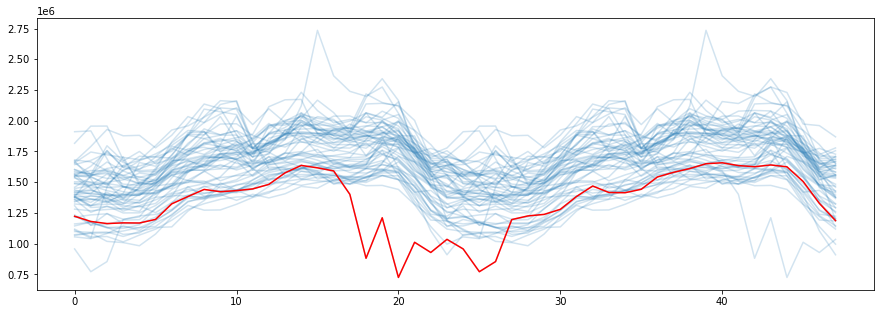

In [199]:
df4 = df2.groupby([df2.index.year, df2.index.day, df2.index.hour])["sumCount"].sum()
df4.rename_axis(index=["year", "day", "hour"], inplace=True)

years = df4.index.get_level_values("year").unique().to_numpy()
days = df4.index.get_level_values("day").unique().to_numpy()

fig, ax = plt.subplots(figsize=(15,5))

for year in years:
    for day, nextday in zip(days[:-1], days[:-1]+1):
        _, y = getdfcols(df4.loc[year].loc[day:nextday])
        x = np.arange(0, 48)
        ax.plot(x, y, "-", alpha=0.2, color="C0")
ax.plot()
attack_df2 = df2.loc[datetime.datetime(2019, 9, 6, 0):datetime.datetime(2019, 9, 7, 23)]
attack_per_hour = attack_df2.groupby([attack_df2.index.day, attack_df2.index.hour]).sum("sumCount")
ax.plot(x, attack_per_hour, color="red")
plt.show()

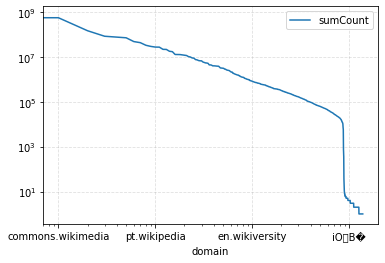

In [333]:
dfg = df2.groupby("domain").sum("sumCount").sort_values("sumCount", ascending=False)
dfg.plot(loglog=True)
plt.grid(linestyle="--", alpha=0.4)

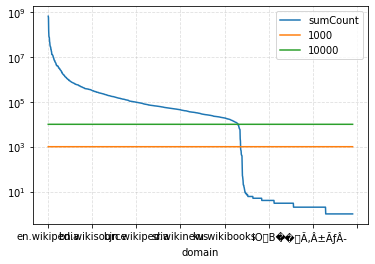

In [334]:
dfg.plot(logy=True, linestyle="-")
plt.plot(dfg.index, [1000]*len(dfg), label="1000")
plt.plot(dfg.index, [10000]*len(dfg), label="10000")
plt.grid(linestyle="--", alpha=0.4, which="both")
plt.legend()
plt.show()

In [349]:
treshold = 100000
topn = 50
# doing treshold with fixed view number
df_treshold = df2[["sumCount", "domain"]].groupby("domain").transform("sum").transform(lambda row: row > treshold)
# doing treshold with top n entries
# df_topn = df2[["sumCount", "domain"]].groupby("domain").sum("sumCount").sort_values("sumCount", ascending=False)[0:topn]
# df_treshold = df2.domain.isin(df_topn.index).to_frame().rename(columns={"domain": "sumCount"})

In [350]:
df6 = df2.copy()
df6.loc[df_treshold["sumCount"], "newDomain"] = df6[df_treshold["sumCount"]].domain
df6.loc[~df_treshold["sumCount"], "newDomain"] = "combined.domain"
print(len(df6.newDomain.unique()))

393


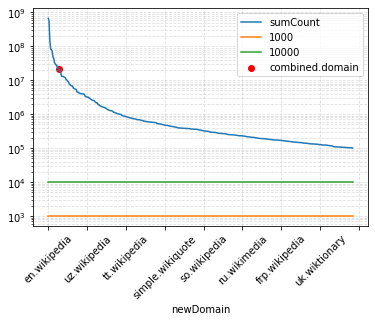

In [365]:
# plt.figure()
dfg2 = df6.groupby("newDomain").sum("sumCount").sort_values("sumCount", ascending=False)
dfg2.plot(logy=True, linestyle="-")
plt.plot(dfg2.index, [1000]*len(dfg2), label="1000")
plt.plot(dfg2.index, [10000]*len(dfg2), label="10000")
plt.xticks(rotation=45)
plt.scatter("combined.domain", dfg2.loc["combined.domain"], color="red", label="combined.domain")
plt.grid(linestyle="--", alpha=0.4, which="both")
plt.legend()
plt.show()

In [ ]:
df5 = df2.groupby([df2.index.year, df2.index.day, df2.index.hour])["sumCount"].sum()

In [22]:
def strsplit(s):
    sl = s.split(".")
    if len(sl) == 2:
        return sl
    elif len(sl) == 1:
        return ["", *sl]
    elif len(sl) > 2:
        print(sl)
        return sl[:2]
    else:
        print(sl)

In [28]:
df2[0:100000].apply(lambda r: strsplit(r.domain), axis=1, result_type="expand")

,0,1
date,,
2018-09-01 00:00:00,cs,wiktionary
2018-09-01 00:00:00,tg,wiktionary
2018-09-01 00:00:00,tn,wikipedia
2018-09-01 00:00:00,bh,wikipedia
2018-09-01 00:00:00,la,wikisource
...,...,...
2018-09-03 16:00:00,zh,wikibooks
2018-09-03 16:00:00,ba,wikipedia
2018-09-03 16:00:00,cdo,wikipedia


In [35]:
df2[df2["domain"] == '����']

,trafficType,domain,sumCount
date,,,
2018-09-02 07:00:00,spider,����,1
2018-09-17 10:00:00,spider,����,1
2018-09-21 17:00:00,spider,����,1


In [33]:
df2.domain.unique().tolist()

['cs.wiktionary',
 'tg.wiktionary',
 'tn.wikipedia',
 'bh.wikipedia',
 'la.wikisource',
 'te.wiktionary',
 'th.wikisource',
 'pnb.wikipedia',
 'kg.wikipedia',
 'xmf.wikipedia',
 'gn.wikipedia',
 'de.wikibooks',
 'za.wiktionary',
 'ps.wikivoyage',
 'gu.wikisource',
 'ku.wikipedia',
 'zh.wikiquote',
 'ja.wikiquote',
 'gag.wikipedia',
 'gd.wikipedia',
 'hy.wikibooks',
 'srn.wikipedia',
 'sa.wikipedia',
 'pdc.wikipedia',
 'ang.wikipedia',
 'kr.wikipedia',
 'lb.wikipedia',
 'az.wikisource',
 'qu.wikiquote',
 'ny.wikipedia',
 'pl.wikinews',
 'fur.wikipedia',
 'ro.wikipedia',
 'ro.wikibooks',
 'de.wiktionary',
 'oc.wiktionary',
 'bjn.wikipedia',
 'th.wikipedia',
 'na.wikipedia',
 'beta.wikiversity',
 'nso.wikipedia',
 'mi.wikipedia',
 'id.wikibooks',
 'dv.wikipedia',
 'si.wikibooks',
 'sm.wiktionary',
 'tr.wikiquote',
 'ro.wikivoyage',
 'min.wikipedia',
 'vi.wikivoyage',
 'yo.wikipedia',
 'km.wiktionary',
 'ja.wikipedia',
 'uk.wikisource',
 'ho.wikipedia',
 'it.wikibooks',
 'gor.wikipedia',
 